<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DallE-mini/Dall_E_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 175 kB 7.8 MB/s 
     |████████████████████████████████| 4.4 MB 54.5 MB/s 
     |████████████████████████████████| 235 kB 50.7 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 1.8 MB 48.2 MB/s 
     |████████████████████████████████| 197 kB 63.4 MB/s 
     |████████████████████████████████| 596 kB 18.8 MB/s 
     |████████████████████████████████| 217 kB 66.5 MB/s 
     |████████████████████████████████| 140 kB 52.2 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
     |████████████████████████████████| 72 kB 643 kB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 1.8 MB/s 
     |████████████████████████████████| 181 kB 61.2 MB/s 
     |████████████████████████████████| 145 kB 62.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [2]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [3]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [4]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

In [6]:
DALLE_COMMIT_ID = None
DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

In [7]:
# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:15.9


In [15]:
!ls -la ~/.cache/wandb/artifacts/obj/md5

total 36
drwxr-xr-x 9 root root 4096 Jul  1 23:32 .
drwxr-xr-x 3 root root 4096 Jul  1 23:32 ..
drwxr-xr-x 2 root root 4096 Jul  1 23:32 17
drwxr-xr-x 2 root root 4096 Jul  1 23:32 1f
drwxr-xr-x 2 root root 4096 Jul  1 23:32 32
drwxr-xr-x 2 root root 4096 Jul  1 23:32 52
drwxr-xr-x 2 root root 4096 Jul  1 23:32 78
drwxr-xr-x 2 root root 4096 Jul  1 23:32 e9
drwxr-xr-x 2 root root 4096 Jul  1 23:32 f1


In [16]:
!du -sh ~/.cache/wandb/artifacts/obj/md5

1.7G	/root/.cache/wandb/artifacts/obj/md5


In [17]:
# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [18]:
# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [19]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

In [20]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [23]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [24]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:12.2


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

In [37]:
#prompts = ['An bear and a rabbit is walking in a dense jungle']

prompts = ['logo of an armchair in the shape of an avocado']

In [38]:
tokenized_prompts = processor(prompts)

In [39]:
tokenized_prompt = replicate(tokenized_prompts)

In [40]:
# number of predictions per prompt
n_predictions = 4

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [41]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

Prompts: ['logo of an armchair in the shape of an avocado']



  0%|          | 0/4 [00:00<?, ?it/s]

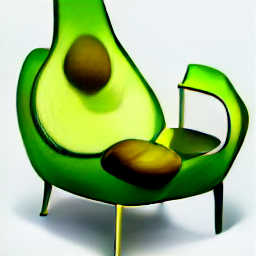

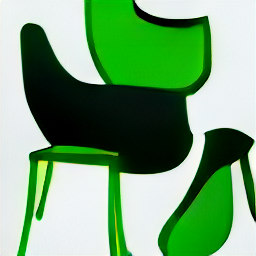

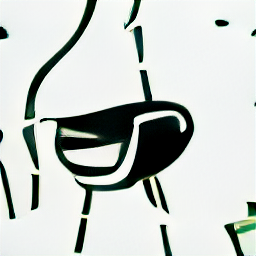

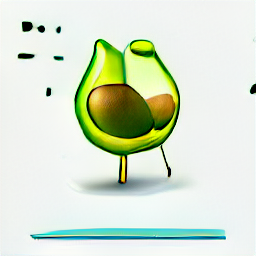

In [42]:
print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()